# <center>Network Science</center>

## <center>Home Assignment #2: Network models</center>

### <center>Student: *Boris Tseytlin*</center>

#### <hr /> General Information

**Due Date:** 23.03.2019<br \>
**Late submission policy:** -2 points per day <br \>


Please send your reports to <network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2019] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

## Problems

### Task 1

Consider Barabasi and Albert dynamical grow model. Two main ingredients of this model are *network growing* and *prefferential attachment*. Implement two restricted B&A-based models:
<br \>

**Model A**
<br \>
Lack of prefferential attachment, that is at each time-step form edges uniformly at random while network keeps growing.

**Model B**
<br \>
Lack of growing, that is fix total number of nodes, on each time-step randomly choose one and form edges with prefferential attachment.
<br \>

1. Generate networks according to the models above ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
4. Is scale-free property conserved in these models?

Analyse results with respect to various parameter settings

In [199]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import random
from sklearn.metrics import r2_score

%matplotlib inline

In [200]:
def draw_nx(g):
    plt.figure(figsize=(13,13))
    plt.axis('off')
    nx.draw_networkx(g,
                node_size = 100,
                node_color='black',
                edge_color = 'gray',
                with_labels = False,
                font_size=16,
                alpha=0.7)
    plt.show()

In [201]:
def get_stats_df():
    return pd.DataFrame(columns=['num_nodes','avg_node_degree','avg_node_age','avg_degree_to_age'])

def get_stats_row(graph, n_nodes):
    row = {
        'num_nodes': n_nodes,
    }
    degree = pd.Series(graph.degree())
    row['avg_node_degree'] = degree.mean()
    row['avg_node_age'] = np.array(degree.index).mean()
    row['avg_degree_to_age'] = (degree/(np.array(degree.index)+1)).mean()
    return row

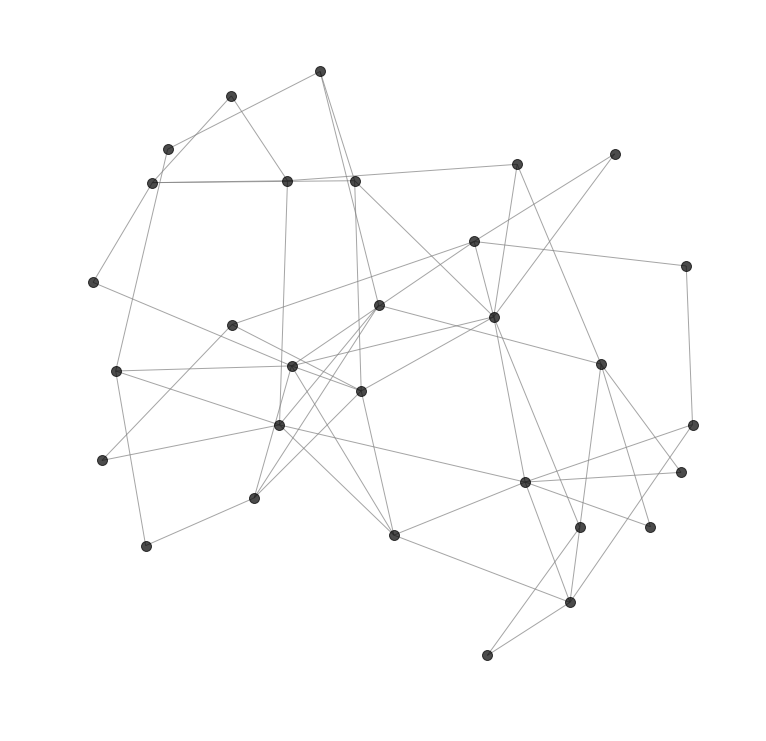

In [202]:
def ba_model_no_pa_generator(n_nodes, m_edges, compute_stats_every=100):
    """Model A.
    
    Barabasi and Albert model, no preferential attachment"""
    graph = nx.Graph()
    graph.add_node(0)
    for i in range(m_edges+1):
        for j in range(i+1, m_edges+1):
            graph.add_edge(i,j)
    
    stats_df = get_stats_df()

    for t in range(m_edges+1, n_nodes):
        initial_nodes = graph.nodes()
        
        # growth
        graph.add_node(t)
        
        nodes_to_pick = list(initial_nodes)
        # connect to m random existing nodes, probability is uniform
        targets = np.random.choice(range(1, t), size=m_edges, replace=False)
        for target in targets:
            graph.add_edge(t, target)            
        
        if (t+1) % compute_stats_every == 0:
            stats_df.loc[len(stats_df)] = get_stats_row(graph, t+1)
            
    return graph, stats_df

draw_nx(ba_model_no_pa_generator(30, 2)[0])

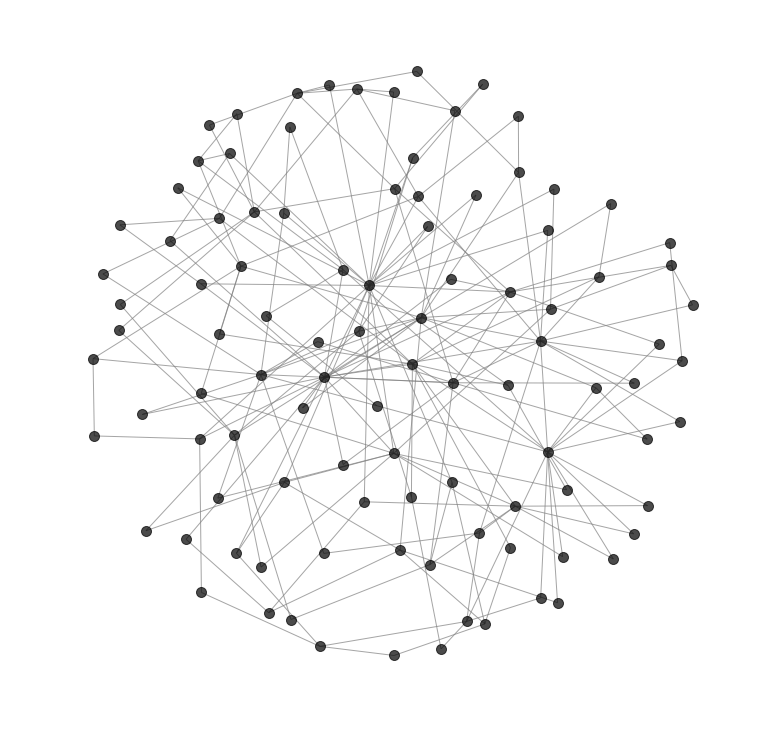

In [203]:
def ba_model_no_growth_generator(n_nodes, m_edges, compute_stats_every=100):
    """Model B
    
    Barabasi and Albert model, no growth, preferential attachment"""
    
    stats_df = get_stats_df()      
    graph = nx.Graph()
    graph.add_nodes_from(range(n_nodes))
    
    for i in range(m_edges+1):
        for j in range(i+1, m_edges+1):
            graph.add_edge(i,j)
            
            
    for t in range(m_edges+1, n_nodes):
        # preferential attachment
        neighbors = graph.neighbors(t)
        target_nodes = set(range(n_nodes)).difference([t]).difference(neighbors)
        degrees = pd.Series(graph.degree())[target_nodes].astype(float)
        normed_degrees = (degrees)/(degrees).sum()
        targets = np.random.choice(normed_degrees.index, size=m_edges, p=normed_degrees.values, replace=False)
        for target in targets:
            graph.add_edge(t, target)
            
        if (t+1) % compute_stats_every == 0:
            stats_df.loc[len(stats_df)] = get_stats_row(graph, t+1)
        
    return graph, stats_df
draw_nx(ba_model_no_growth_generator(100, 2, compute_stats_every=10)[0])

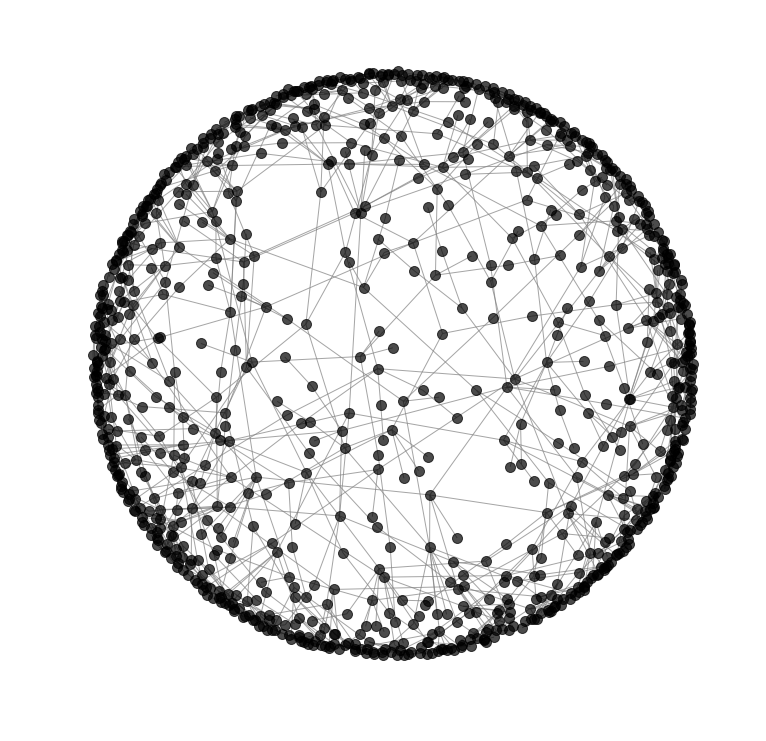

In [204]:
m = 1
graph_a, stats_df_a = ba_model_no_pa_generator(1000, m, compute_stats_every=100)
draw_nx(graph_a)

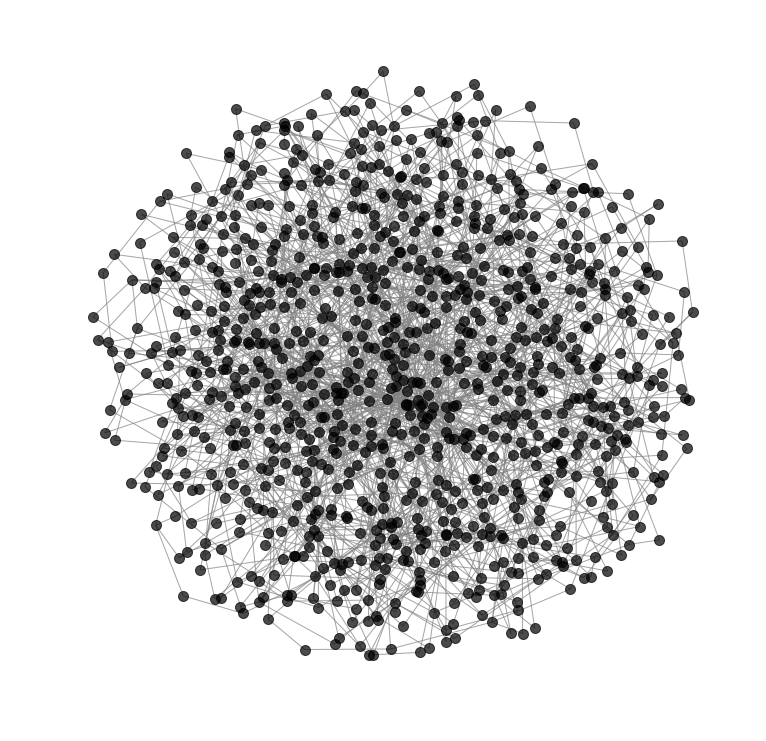

In [205]:
draw_nx(ba_model_no_pa_generator(1000, 2, compute_stats_every=10000)[0])

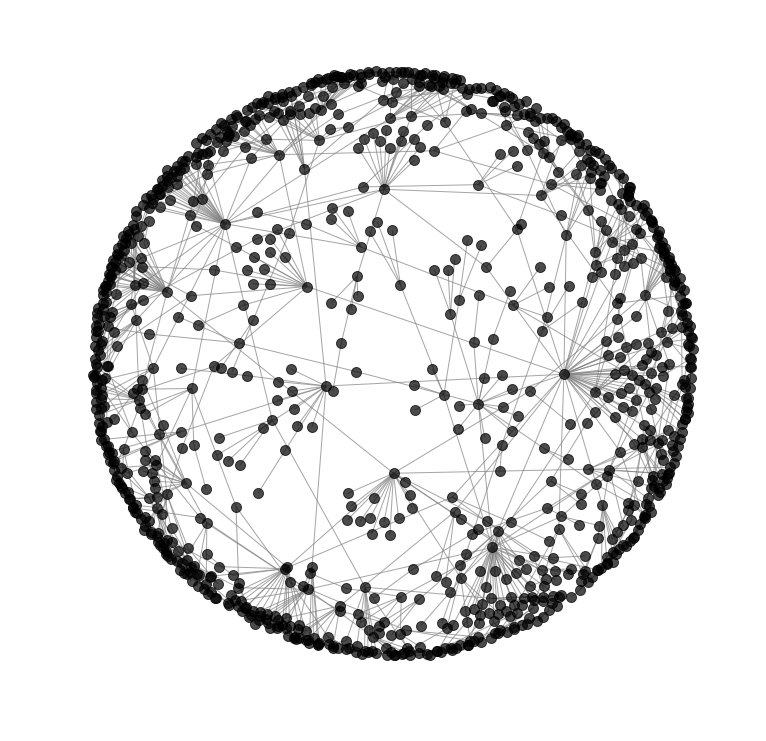

In [206]:
m = 1
graph_b, stats_df_b = ba_model_no_growth_generator(1000, m, compute_stats_every=100)
draw_nx(graph_b)

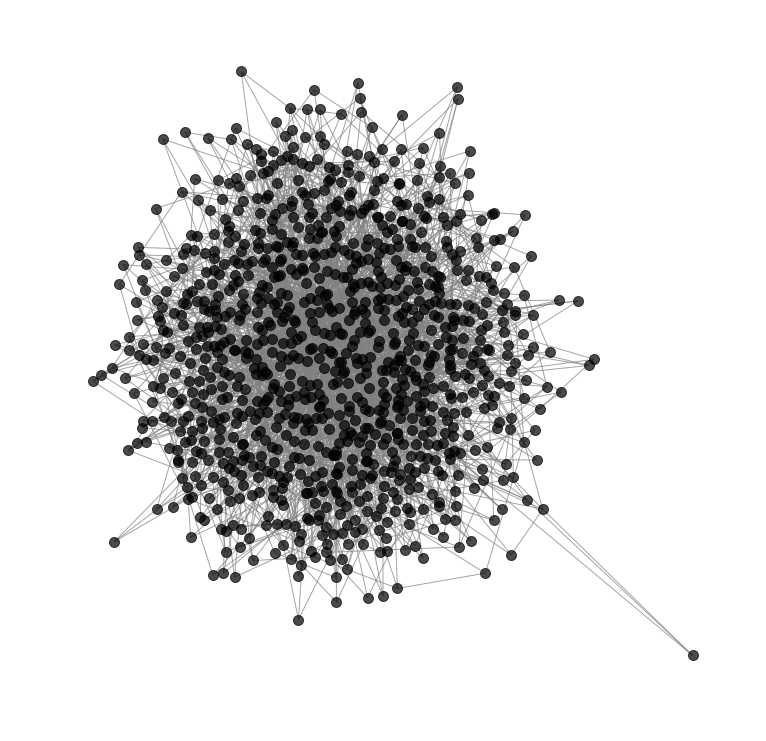

In [207]:
draw_nx(ba_model_no_growth_generator(1000, 3, compute_stats_every=10000)[0])

$m > 1$ produces very tightly connected graphs, for both models.

### Draw PDF/CDF, describe and compute property distributions

In [130]:
def degree_pdf(graph):
    degree = pd.Series(graph.degree())
    degree = degree.sort_values()
    vcounts = degree.value_counts()
    
    degree_keys = pd.Series(vcounts.index).sort_values().values
    s = vcounts.sum()
    pdf=(vcounts/s)[degree_keys]
    
    return degree_keys, pdf

def plot_pdf(graph):
    degree_keys, pdf = degree_pdf(graph)
    plt.plot(degree_keys, pdf,'r')
    plt.title('Node degree PDF')
    plt.xlabel('$k$')
    plt.ylabel('$p(k)$')

def degree_cdf(graph):
    degree_keys, pdf = degree_pdf(graph)
    cdf = pdf.cumsum()
    
    return degree_keys, cdf

def plot_cdf(graph):
    degree_keys, cdf = degree_cdf(graph)
    plt.plot(degree_keys, cdf,'r')
    plt.title('Node degree CDF')
    plt.xlabel('$k$')
    plt.ylabel('$cdf(k)$')
    
def fit_log_log(degree_vals):
    x_est = np.log(range(1, len(degree_vals)+1))
    y_est = np.log(degree_vals)
    s = len(x_est)

    X = np.vstack([np.ones(s), x_est]).T
    Beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_est)

    a_linreg = -Beta[1]
    c_linreg = Beta[0]
    
    idx = np.argsort(x_est)
    yt = X[idx,:].dot(Beta)
    xt = X[idx,1]
    
    plt.plot(x_est, y_est, '.')
    plt.plot(xt, yt, '-')
    
    print 'R squared:', r2_score(yt, y_est)
    mse = (np.square(yt - y_est)).mean()
    print 'MSE', mse

    return a_linreg, c_linreg

### Model A PDF/CDF

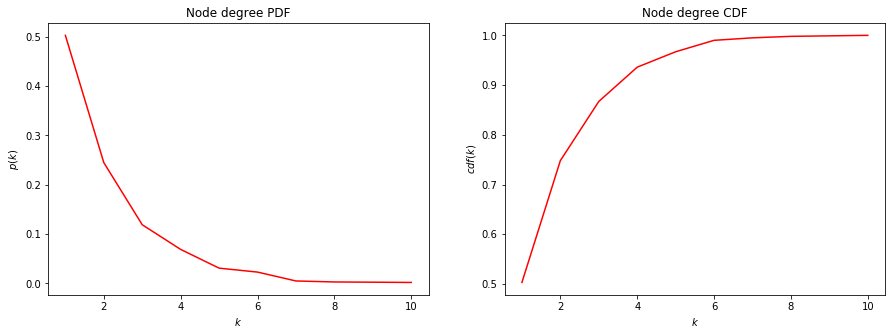

In [208]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plot_pdf(graph_a)
plt.subplot(1,2,2)
plot_cdf(graph_a)
plt.show()

### Estimate model A power law paramters

R squared: 0.875583080693401
MSE 0.3795074015791977


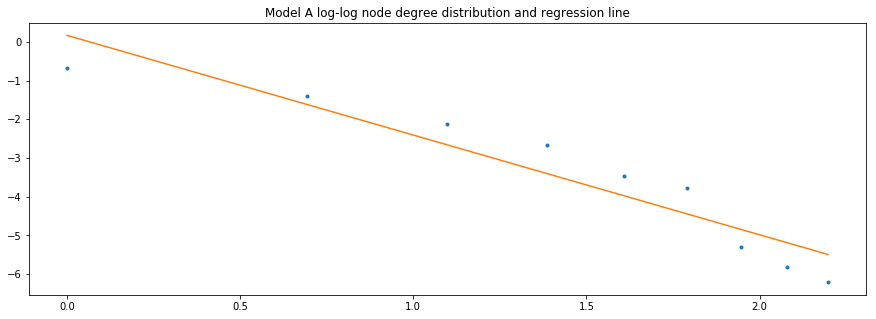

Estimated alpha 2.575488067847
Estimated C 0.16743484346401627


In [209]:
degree_keys, pdf_a = degree_pdf(graph_a)
plt.figure(figsize=(15, 5))
plt.title('Model A log-log node degree distribution and regression line')
alpha_a, C= fit_log_log(pdf_a)
plt.show()
print 'Estimated alpha', alpha_a
print 'Estimated C', C

After looking at the PDF and trying to fit a regression in log-log, we conclude that conclude Model A has no scale-free property. Without preferential attachment, node degree distribution tends to geometric instead of power law.

**Scale-free property is not preserved for Model A**

### Model B PDF/CDF

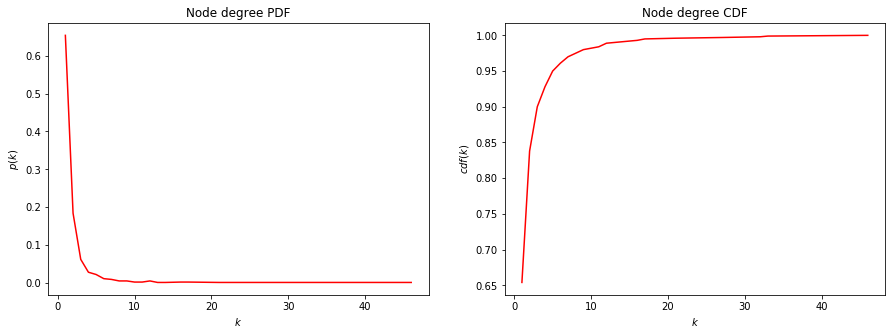

In [210]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plot_pdf(graph_b)
plt.subplot(1,2,2)
plot_cdf(graph_b)
plt.show()

### Estimate model B power law parameters

R squared: 0.9622809949579265
MSE 0.12235738778276953


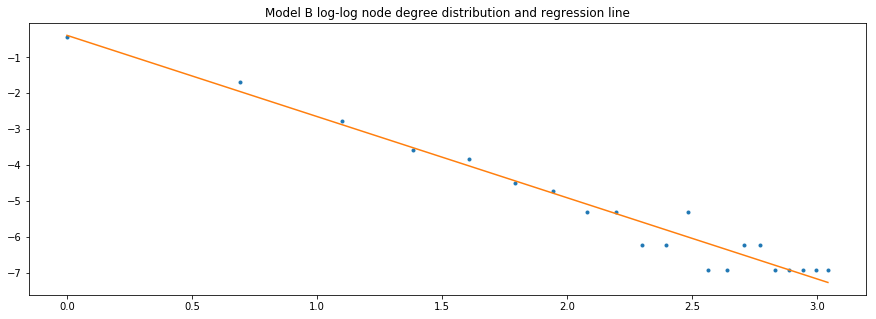

Estimated alpha 2.2573089473183474
Estimated C -0.38959145358199554


In [211]:
degree_keys, pdf_b = degree_pdf(graph_b)
plt.figure(figsize=(15, 5))
plt.title('Model B log-log node degree distribution and regression line')
alpha_b, C= fit_log_log(pdf_b)
plt.show()
print 'Estimated alpha', alpha_b
print 'Estimated C', C

Model B PDF has the expected steep shape for a powerlaw. 
We know that Model B is a limiting case of the Barabási–Albert model and it's distribution is expected to approach Gaussian. However for $N$ between $1000$ and $3000$ we observe a power law distribution and scale-free structure.

**For given parameters the scale-free property is preserved for Model B.**

### Examine dependencies

In [212]:
m=2
steps = np.linspace(50, 1500, 20)
graphs_a = [ba_model_no_pa_generator(int(n), m, compute_stats_every=max(steps)+1)[0] for n in steps]
graphs_b = [ba_model_no_growth_generator(int(n), m, compute_stats_every=max(steps)+1)[0] for n in steps]

In [213]:
avg_paths_a = [nx.average_shortest_path_length(g) for g in graphs_a]
avg_paths_b = [nx.average_shortest_path_length(g) for g in graphs_b]

In [214]:
avg_clustering_a = [nx.transitivity(g) for g in graphs_a]
avg_clustering_b = [nx.transitivity(g) for g in graphs_b]

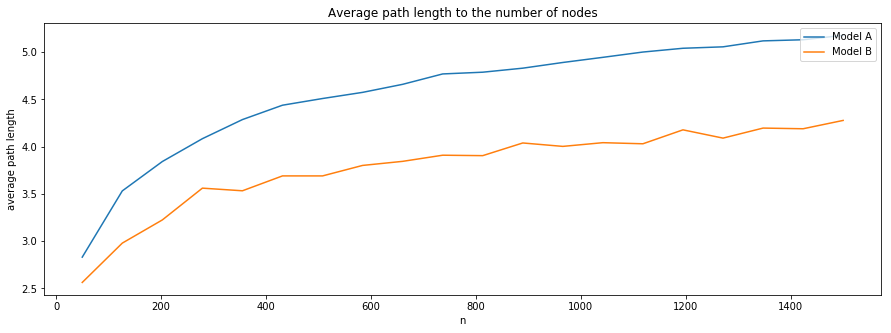

In [215]:
fig = plt.figure(figsize=(15,5))
plt.plot(steps, avg_paths_a, label='Model A')
plt.plot(steps, avg_paths_b, label='Model B')
plt.title('Average path length to the number of nodes')
plt.xlabel('n')
plt.ylabel('average path length')
plt.legend(loc='upper right')
plt.show()

Model B networks have smaller average path length and smaller growth of it too. This is due to Mobel B being more of a power law model.

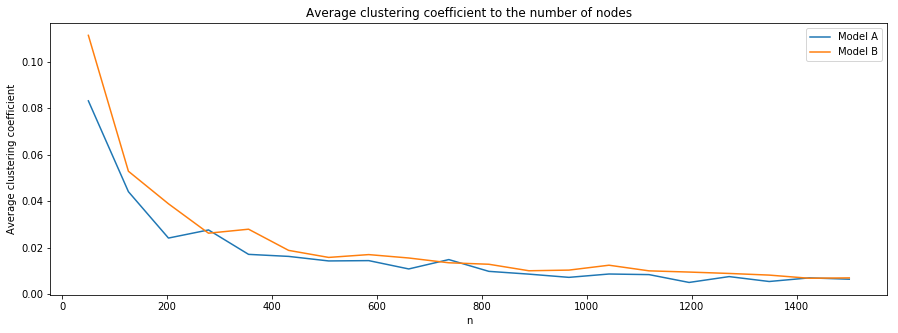

In [216]:
fig = plt.figure(figsize=(15,5))
plt.plot(steps, avg_clustering_a, label='Model A')
plt.plot(steps, avg_clustering_b, label='Model B')
plt.title('Average clustering coefficient to the number of nodes')
plt.xlabel('n')
plt.ylabel('Average clustering coefficient')
plt.legend(loc='upper right')
plt.show()

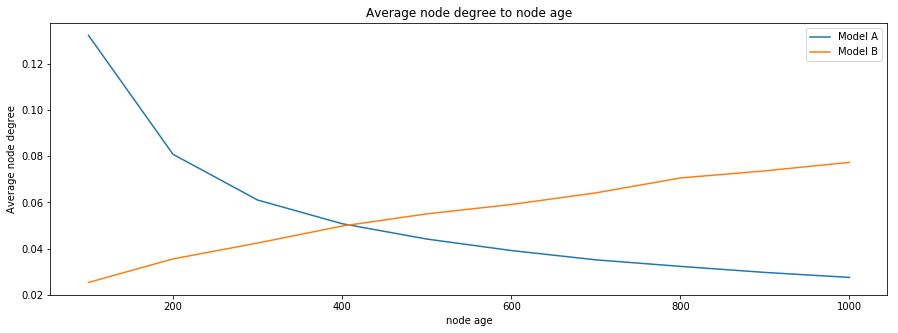

In [217]:
fig = plt.figure(figsize=(15,5))
plt.plot(stats_df_a.num_nodes, stats_df_a.avg_degree_to_age, label='Model A')
plt.plot(stats_df_b.num_nodes, stats_df_b.avg_degree_to_age, label='Model B')
plt.title('Average node degree to node age')
plt.xlabel('node age')
plt.ylabel('Average node degree')
plt.legend(loc='upper right')
plt.show()

**Model A:**

As more nodes are added, the amount of "leaf nodes" (connected only to one other node) grows for Mobel B. The probability for a node to get a new edge stays constant, but the amount of nodes increases. So the average node degree to node age falls as network grows.

**Model B:**

Older nodes get more new edges on average, so their degree grows. So average node degree grows. Network becomes denser, more interconnected.

### <hr /> Task 2

Consider the following  "Vertex copying model" of growing network.

At every time step a random vertex from already existing vertices is selected and duplicated together with all edges, such that  every edge of the  vertex
* is copied with probability $q$
* is rewired to any other randomly selected vertex with probability $1-q$


Starting state is defined by some small number of randomly connected vertices.

The model can generate both directed and undirected networks.

1. Generate  graphs based on the model ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
    
Analyse results with respect to various parameter settings

In [185]:
def vertex_copying_model_generator(q, n_nodes, directed=False, n_initial=10, compute_stats_every=100):
    graph = nx.gnp_random_graph(n=n_initial,p=0.75,directed=directed) 
    
    stats_df = get_stats_df()
    for t in range(n_initial, n_nodes):
        graph.add_node(t)
        sample_node = random.choice(range(t))
        edges = graph.edges([sample_node])
        
        for _, target in edges:
            dice = random.random()
            if dice > q:
                # can't rewire to same node or already connected nodes
                possible_targets = list(set(range(t)).difference([target]).difference(graph.neighbors(t)))
                target = random.choice(possible_targets)
            graph.add_edge(t, target)
            
        if directed:
            edges = graph.in_edges([sample_node])
            for source, _ in edges:
                dice = random.random()
                if dice > q:
                    possible_sources = list(set(range(t)).difference([source]).difference(graph.neighbors(t)))
                    source = random.choice(possible_sources)
                graph.add_edge(source, t)
                
        if not directed and (t+1) % compute_stats_every == 0:
            stats_df.loc[len(stats_df)] = get_stats_row(graph, t+1) 
                        
    return graph, stats_df

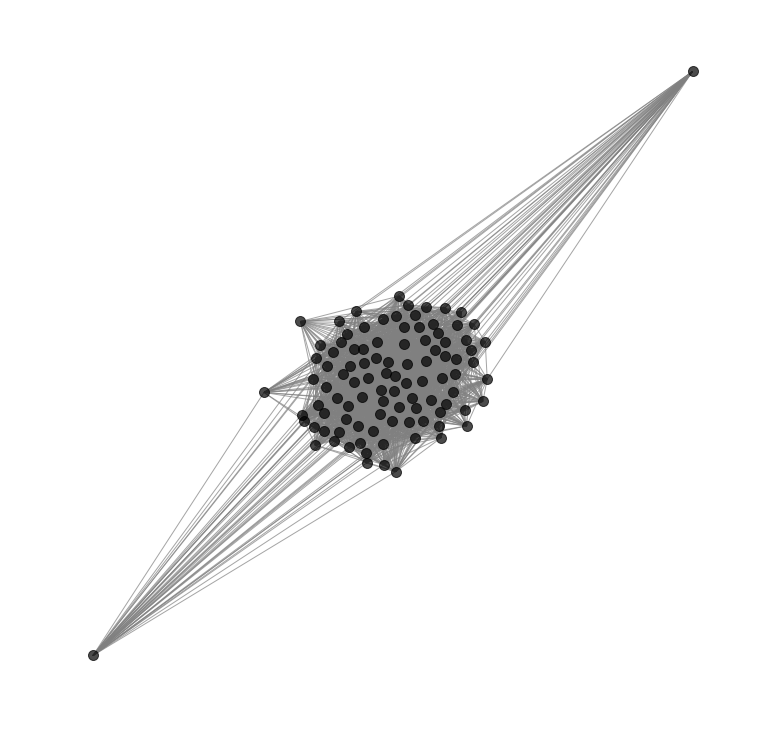

In [186]:
draw_nx(vertex_copying_model_generator(0.5, 100)[0])

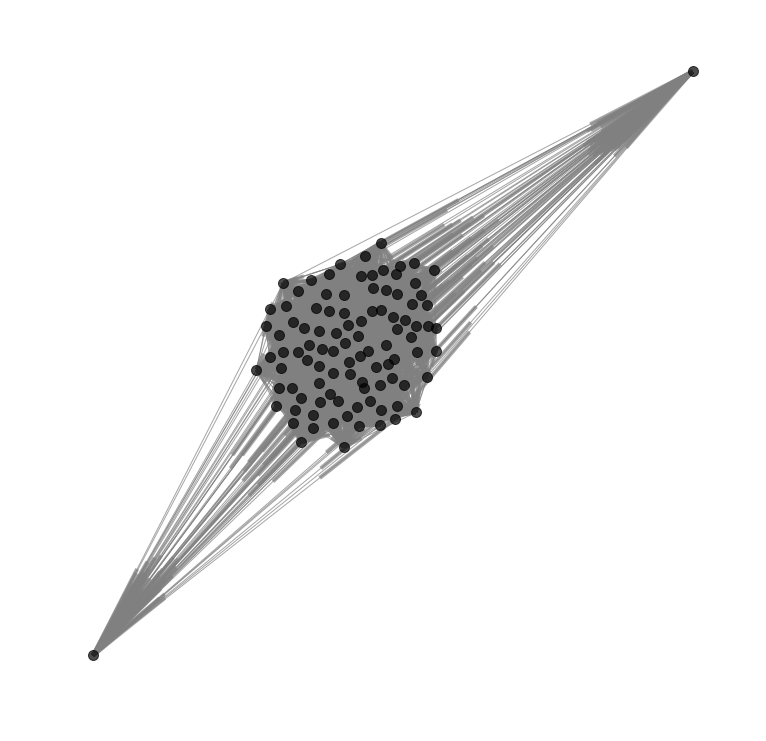

In [188]:
draw_nx(vertex_copying_model_generator(0.5, 100, directed=True)[0])

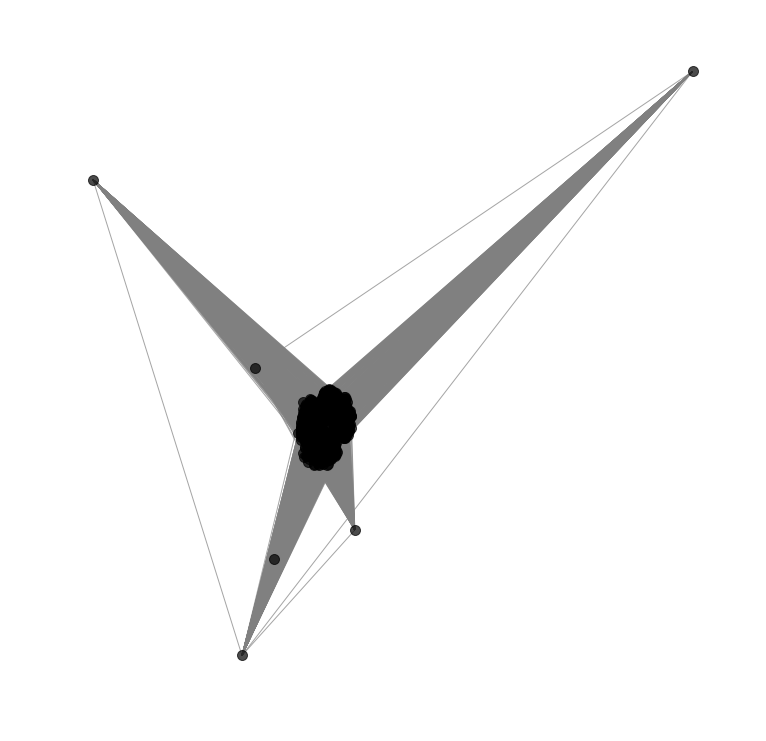

In [189]:
graph_vc, stats_df_vc = vertex_copying_model_generator(0.8, 1100, compute_stats_every=250)
draw_nx(graph_vc)

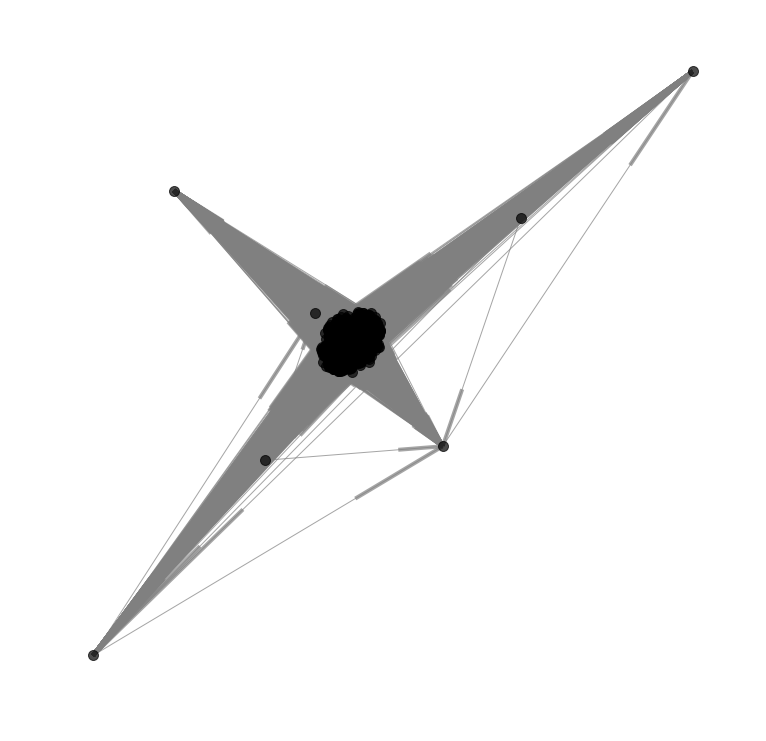

In [190]:
graph_vc_dir, _ = vertex_copying_model_generator(0.8, 1100, compute_stats_every=250000, directed=True)
draw_nx(graph_vc_dir)

### VC model PDF/CDF

Non-directed graph

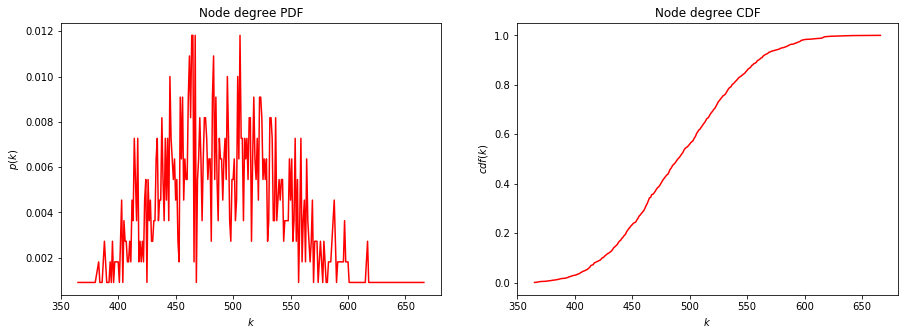

In [191]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plot_pdf(graph_vc)
plt.subplot(1,2,2)
plot_cdf(graph_vc)
plt.show()

Directed graph

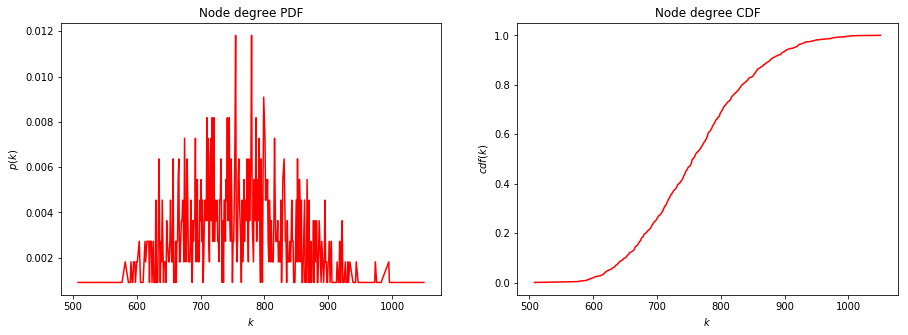

In [192]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plot_pdf(graph_vc_dir)
plt.subplot(1,2,2)
plot_cdf(graph_vc_dir)
plt.show()

Node distribution is clearly **not powerlaw** for this model. It resembles Guassian.
We can estimate it's parameters.

In [193]:
print 'Mean degree:', np.mean(graph_vc.degree().values())
print 'Degree std:', np.std(graph_vc.degree().values())

Mean degree: 491.9981818181818
Degree std: 52.314694584040986


### Examine dependencies

In [194]:
steps = np.linspace(50, 1500, 10)
graphs_vc = [vertex_copying_model_generator(0.8, int(n), compute_stats_every=n+1)[0] for n in steps]

In [195]:
avg_paths_vc = [nx.average_shortest_path_length(g) for g in graphs_vc]
avg_clustering_vc = [nx.transitivity(g) for g in graphs_vc]

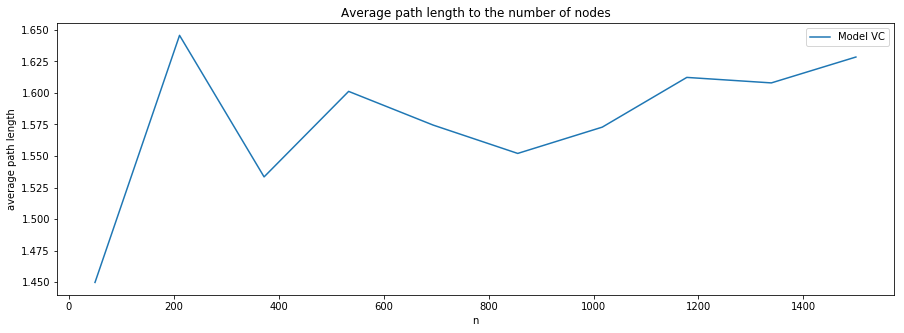

In [196]:
fig = plt.figure(figsize=(15,5))
plt.plot(steps, avg_paths_vc, label='Model VC')
plt.title('Average path length to the number of nodes')
plt.xlabel('n')
plt.ylabel('average path length')
plt.legend(loc='upper right')
plt.show()

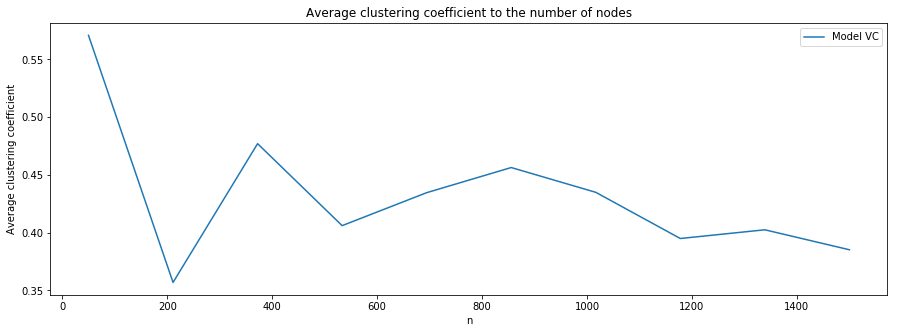

In [197]:
fig = plt.figure(figsize=(15,5))
plt.plot(steps, avg_clustering_vc, label='Model VC')
plt.title('Average clustering coefficient to the number of nodes')
plt.xlabel('n')
plt.ylabel('Average clustering coefficient')
plt.legend(loc='upper right')
plt.show()

There seems to be no significant dependency between target parameters and node amount. The model is very unstable.

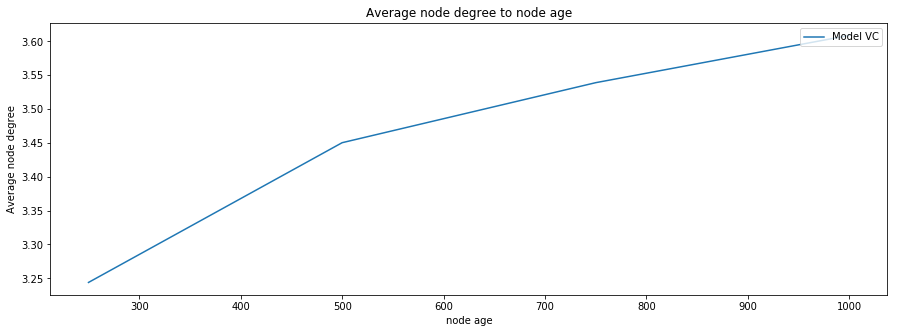

In [198]:
fig = plt.figure(figsize=(15,5))
plt.plot(stats_df_vc.num_nodes, stats_df_vc.avg_degree_to_age, label='Model VC')
plt.title('Average node degree to node age')
plt.xlabel('node age')
plt.ylabel('Average node degree')
plt.legend(loc='upper right')
plt.show()

Average node degree increases very slowly as node age grows.